In [1]:
from google.colab import drive, files
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google.colab'

In [1]:
!pip install gdown

# create directory for storing data
!mkdir -p images

# download zip file with training set
!gdown https://drive.google.com/uc?id=1rTf4DJI2PoM-hgSSSzvpOQcQhui3qh-y && unzip -qq train.zip -d images
!rm train.zip

# download zip with valid set
!gdown https://drive.google.com/uc?id=1yB-KN--FjiWZrA6XwxaSvtXhtcbk80dQ && unzip -qq valid.zip -d images
!rm valid.zip

# download zip with utils
!gdown https://drive.google.com/uc?id=1LbwczJVpDLsMGS7yGMP7z1GCAMg4NCsS && unzip -qq utils.zip
!rm utils.zip

# change dir to the one with data 
!cd /content

/bin/sh: gdown: command not found


# Model V2

Model based on the beta model from here: https://blog.floydhub.com/colorizing-b-w-photos-with-neural-networks/

The preprocessing is done differently - a/b layers in Lab are expressed as a number from [0,1] - a different activation function is used at the last step.

## Setup

First, we install the required libraries.

In [ ]:
# !pip install -r requirements.txt --quiet

Then, we import all the libraries we will use for the project.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# plotting
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [5]:
import numpy as np

import torch 
import torch.nn as nn

from torchvision import transforms

import os, time
from datetime import datetime 

from skimage.color import rgb2lab, lab2rgb
from skimage.io import imshow

from utils import get_random_file
from image_utils import preview_dataloader_lab, combine_channels
from dataloaders import ColorizationImageFolder
from dl_utils import *
from train import *

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
custom_set_seed(42) # for reproducibility

In [7]:
# make output folders
os.makedirs('v2_outputs/color', exist_ok=True)
os.makedirs('v2_outputs/gray', exist_ok=True)
os.makedirs('v2_checkpoints', exist_ok=True)

**Define parameters**

In [8]:
# data loaders
BATCH_SIZE = 32 # number of samples to load per batch
IMG_SIZE = 256

# model
save_images = True
best_loss = 1e10
epochs = 10
print_every = 1
save_every = 5
model_version = 2

## DataLoaders

In [9]:
# define transformations
train_transforms = transforms.Compose([
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5)
])

valid_transforms = transforms.Compose([
    transforms.CenterCrop((IMG_SIZE, IMG_SIZE))
])

In [10]:
# image folders
train_folder = ColorizationImageFolder(root='images/train', model_version=2, transform=train_transforms)
valid_folder = ColorizationImageFolder(root='images/valid', model_version=2, transform=valid_transforms)

In [11]:
# Validation 
train_loader = torch.utils.data.DataLoader(train_folder, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_folder, batch_size=BATCH_SIZE, shuffle=False)

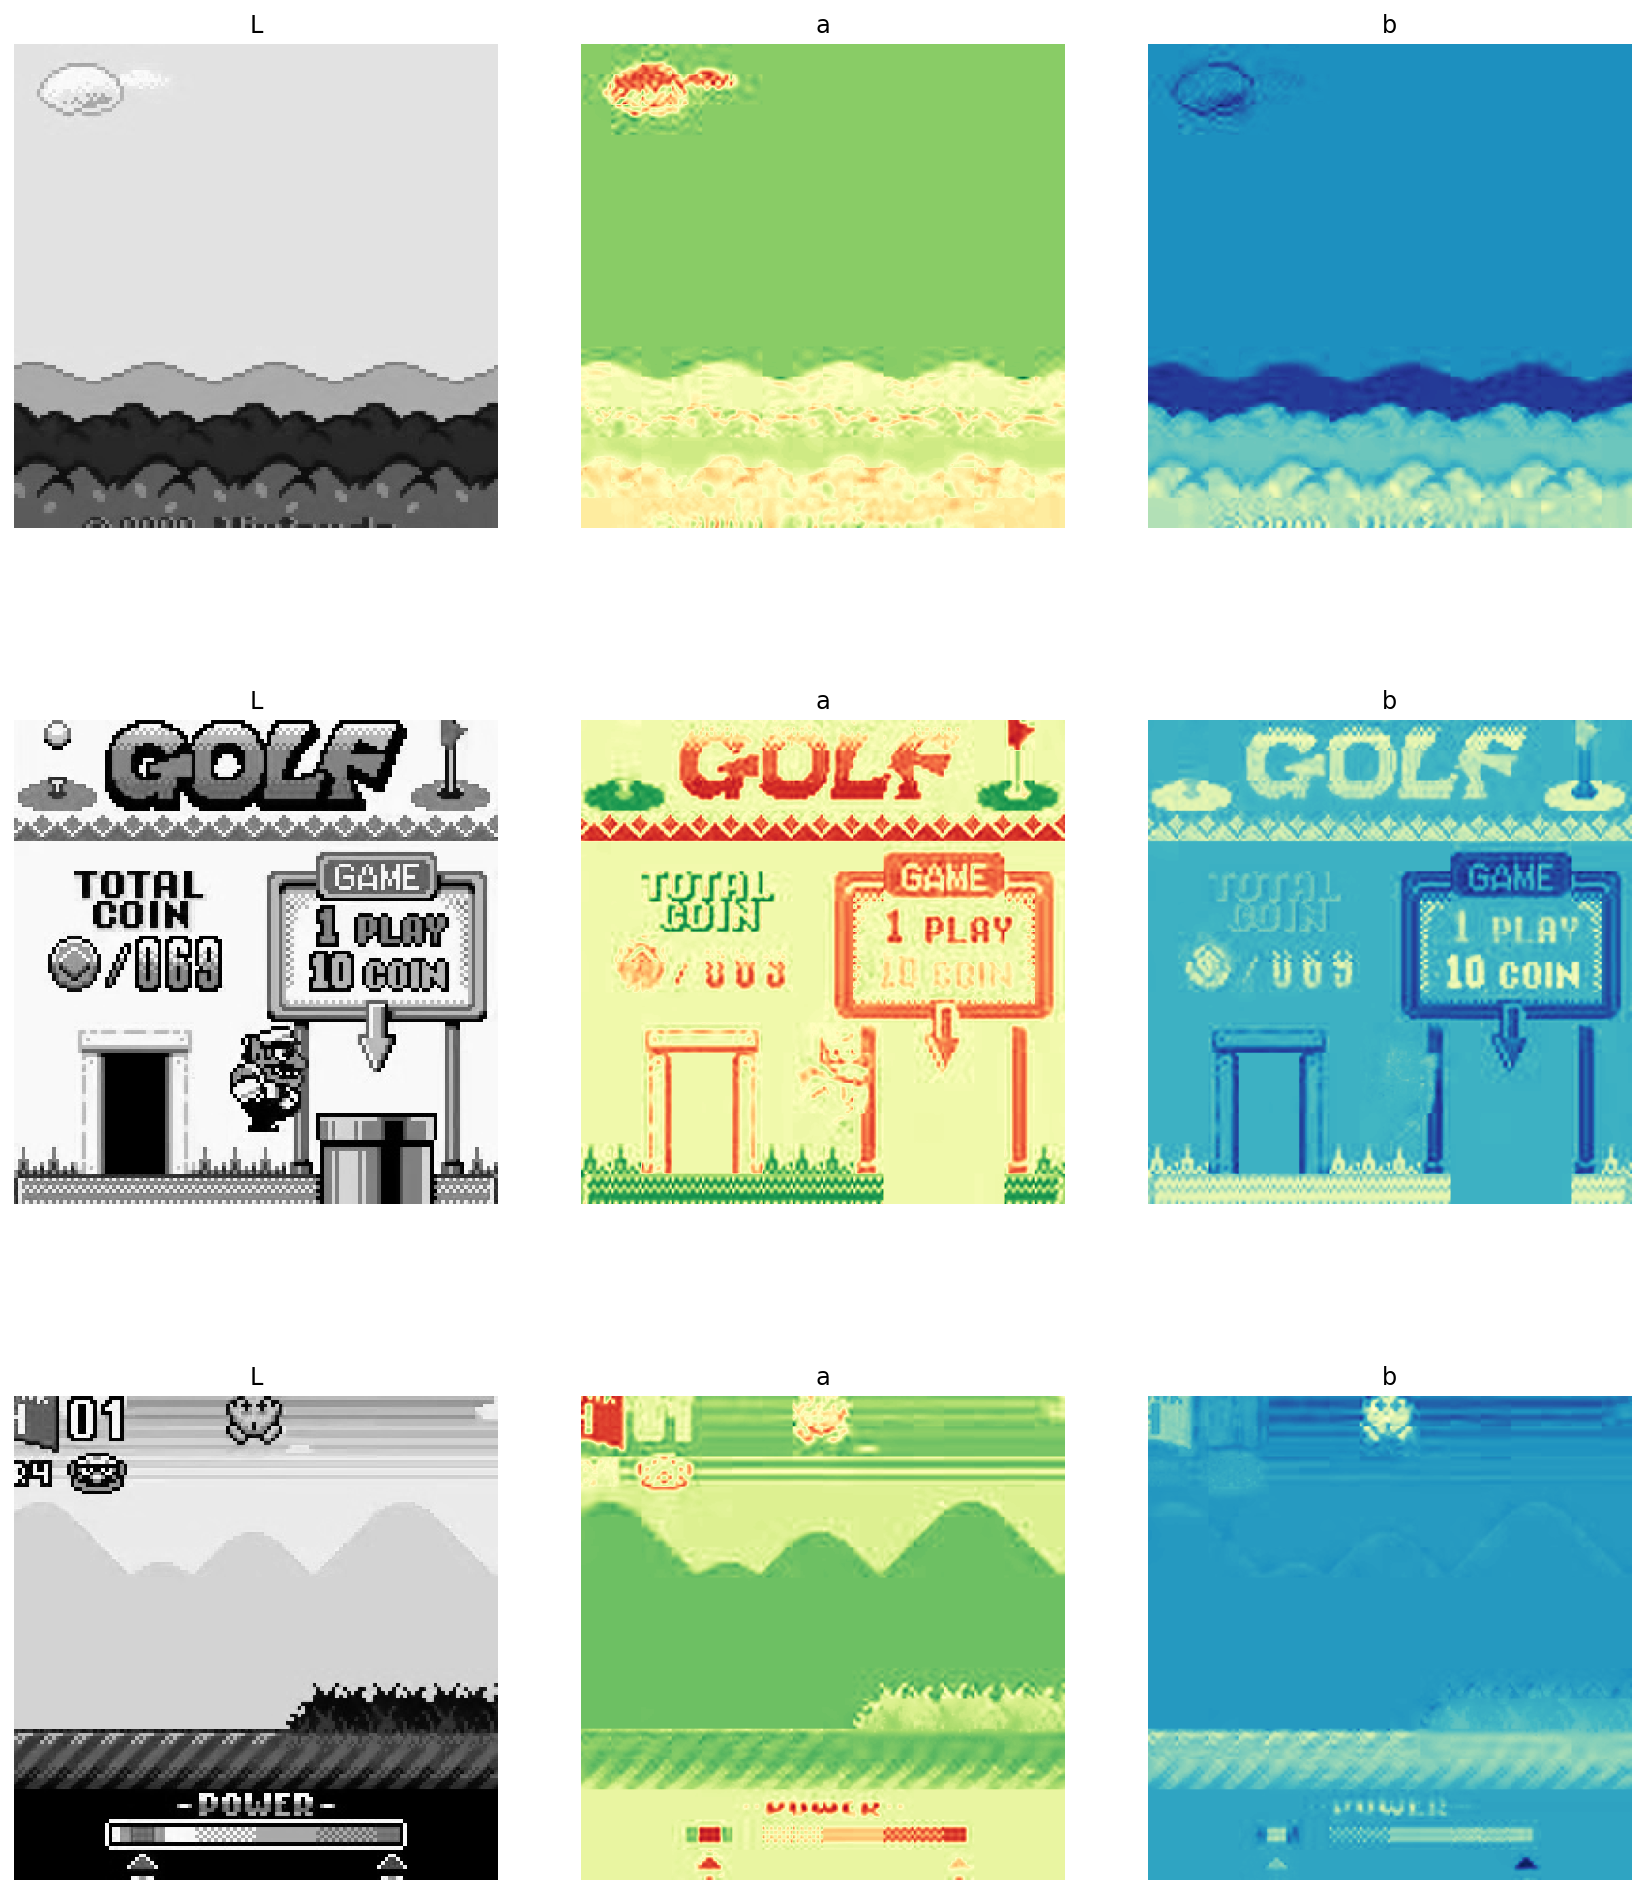

In [12]:
img_gray, img_ab = preview_dataloader_lab(valid_loader)

## Model

In [13]:
class Upsample(nn.Module):
    def __init__(self, scale_factor, mode):
        super(Upsample, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor
        self.mode = mode
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

In [14]:
class ColorCNN(nn.Module):
    def __init__(self):
        super(ColorCNN, self).__init__()

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.upsampling = Upsample(scale_factor=2, mode='nearest')
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=2, padding=1, bias=True)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv9 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv10 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv11 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), stride=1, padding=1, bias=True)
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=2, kernel_size=(3,3), stride=1, padding=1, bias=True)

        self.color = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.conv3,
            self.relu,
            self.conv4,
            self.relu,
            self.conv5,
            self.relu,
            self.conv6,
            self.relu,
            self.conv7,
            self.relu,
            self.conv8,
            self.relu,
            self.conv9,
            self.relu,
            self.upsampling,
            self.conv10,
            self.relu,
            self.upsampling,
            self.conv11,
            self.relu,
            self.conv12,
            self.sigmoid,
            self.upsampling
        )
    
    def forward(self, x):
        return self.color(x)

In [14]:
model = ColorCNN().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

In [15]:
model

ColorCNN(
  (relu): ReLU()
  (tanh): Tanh()
  (upsampling): Upsample()
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), paddin

In [44]:
# set objects for storing metrics
train_losses = []
valid_losses = []
time_meter = AverageMeter()

# Train model
for epoch in range(0, epochs):
    
    start_time = time.time()
    
    # training
    train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # validation
    with torch.no_grad():
        valid_loss = validate(valid_loader, model, criterion, save_images, 
                              'v2_outputs/gray/', 'v2_outputs/color/', device, 
                              epoch, model_version)
        valid_losses.append(valid_loss)
        
    checkpoint = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_losses': train_losses,
            'valid_losses': valid_losses
    }
    
    if epoch % save_every == (save_every - 1):
        save_checkpoint(checkpoint, is_best=False, filename=f'checkpoint_epoch_{epoch}.pth.tar', path='v2_checkpoints')
    
    # Save checkpoint and replace old best model if current model is better
    if valid_loss < best_loss:
        best_loss = valid_loss
        save_checkpoint(checkpoint, is_best=True, filename=f'checkpoint_epoch_{epoch}.pth.tar', path='v2_checkpoints')
        
    end_time = time.time()
    epoch_time = end_time - start_time
    time_meter.update(epoch_time)
        
    if epoch % print_every == (print_every - 1):
        print(f'{datetime.now().time().replace(microsecond=0)} --- '
              f'Epoch: {epoch}\t'
              f'Train loss: {train_loss:.4f}\t'
              f'Valid loss: {valid_loss:.4f}\t'
              f'Epoch time: {epoch_time:.2f} (avg. {time_meter.avg:.2f})')

KeyboardInterrupt: 

In [ ]:
plot_losses(train_losses, valid_losses)

### Manual Evaluation

In [87]:
show_model_results(model, 
                   model_name='Model V2', 
                   model_version=2, 
                   path=get_random_file('images/valid/wario/', 'jpg'), 
                   img_size=IMG_SIZE, 
                   device=device)

## Download checkpoints from Colab

In [ ]:
!zip checkpoints.zip v1_checkpoints

In [ ]:
# save files if in Google Colab
files.download('checkpoints.zip')